# Setup

## Imports

In [1]:
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter

## Define Useful Features

In [2]:
jtplot_style()

In [3]:
_is_even = lambda x: not x % 2

In [4]:
def find_bins(x, f=1):
    n = max(1, int(f * len(x)))
    if _is_even(n): n += 1
    if n > len(x): n -= 2
    
    return np.linspace(x.min(), x.max(), n)

In [5]:
def colorize(distr):
    def _colorize(x):
        if len(x.shape) == 1: x = np.expand_dims(x, 0)
        colors = np.array(['g'] * len(x))
        colors[distr(x)] = 'r'
        return colors.tolist() if len(colors) > 1 else colors[0]
    return _colorize

In [6]:
def to_rgb(x):
    rgb_dict = {'r': [255, 0, 0], 'g': [0, 255, 0], 'b': [0, 0, 255]}
    colors = np.zeros((x.shape[0], x.shape[1], 3), dtype=np.uint8)
    
    unique_colors = np.unique(x)
    if any(c not in rgb_dict.keys() for c in unique_colors):
        raise ValueError('some color keys are unspecified')
        
    for c in unique_colors:
        colors[x == c] = rgb_dict[c]
        
    return colors

In [7]:
def plot_background(cmap, n=100):
    xlim = plt.xlim()
    ylim = plt.ylim()
    xs = np.linspace(plt.xlim()[0], plt.xlim()[1], n)
    ys = np.linspace(plt.ylim()[0], plt.ylim()[1], n)
    
    xs, ys = np.meshgrid(xs, ys)
    xs = xs.reshape(-1); ys = ys.reshape(-1)
    
    colors = np.array(cmap(np.stack([xs, ys], 1))).reshape(n, n)
    if colors.dtype == np.float:
        colors = np.flipud(1 - colors)
        plt.imshow(colors, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), alpha=0.1,
              interpolation='spline16', cmap='RdYlGn', vmin=0, vmax=1)
        return
    
    colors = to_rgb(np.flipud(colors))
    
    plt.imshow(colors, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), alpha=0.1,
              interpolation='spline16')

In [8]:
cross_entropy = lambda input_, target: ((input_ - target) ** 2).mean()

In [9]:
class Distr:
    lin = lambda x: x
    cir = lambda x: np.sqrt(1 - x ** 2)
    sin = lambda x: np.sin(x * 5)
    rnd = lambda x: np.random.randn(len(x))
    exp = lambda x: np.exp(-x)
    sigmoid = lambda x: 1 / (1 + np.exp(-x * 5))

## Load Data

In [10]:
num_pts = 100
_real_distr = lambda x: Distr.sin(Distr.cir(x))
noise = 0.01
val_split = 0.2

In [11]:
def make_data(n, noise, r=1):
    x = r * (np.random.rand(n) * 2 - 1)
    y = _real_distr(x)
    return x, y + np.random.randn(n) * noise
x, y = make_data(num_pts, noise)
x_val, y_val = make_data(int(num_pts * val_split), noise, 1)

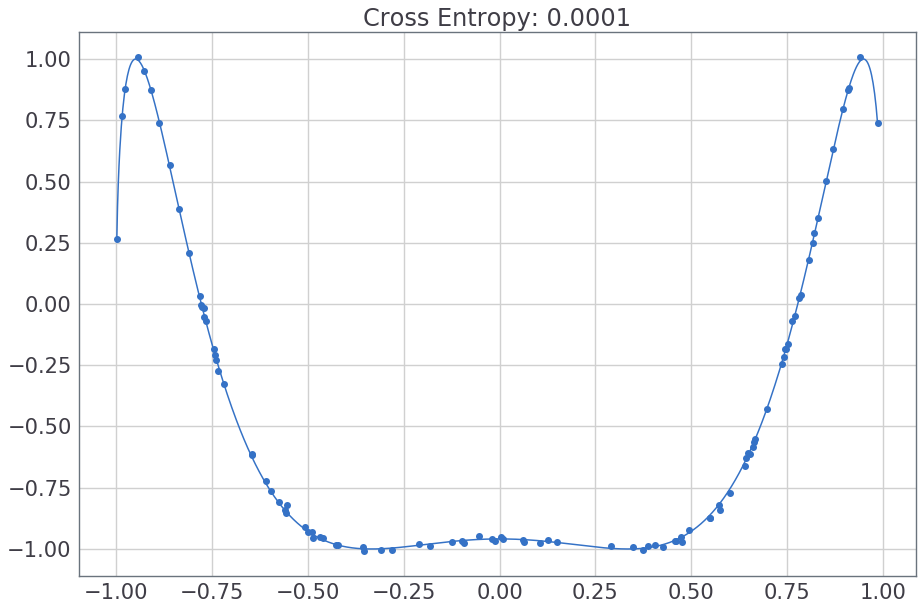

In [12]:
plot(x, y, 'o')
x_ = np.linspace(x.min(), x.max(), len(x) * 10)
plot(x_, _real_distr(x_), 'b')
plt.title(f'Cross Entropy: {cross_entropy(_real_distr(x_val), y_val):.4f}')
plt.show()

# Create Model

In [13]:
class Node:
    def __init__(self, x, y, generation=1, max_gen=np.inf, continous_frac=1):
        self._x = x
        self._y = y
        self._gen = generation
        
        self.val = y.mean() if len(y) > 1 else y[0]
        self.loss = cross_entropy(self.val.repeat(len(y)), y) if len(y) > 1 else 0
        
        self._fertile = lambda: hasattr(self, '_children')
        
        if generation < max_gen:
            try: self._split(max_gen, continous_frac)
            except: pass
            
    def _split(self, max_gen, continous_frac):
        self._find_split(continous_frac)
        
        ids = (self._x[:, self.feature] <= self.split_pt)
        if len(np.where(ids)[0]) == 0 or len(np.where(ids)[0]) == len(self._x): return
        self._children = [Node(self._x[ids], self._y[ids], self._gen + 1, max_gen, continous_frac),
                          Node(self._x[~ids], self._y[~ids], self._gen + 1, max_gen, continous_frac)]
        
    def forward(self, x):
        if self._fertile():
            q = int(x[self.feature] > self.split_pt)
            return self._children[q].forward(x)
        else:
            return self.val
        
    def _print(self):
        print(' ' * (self._gen - 1), f"{self.feature}, {self.split_pt:.2f},"
                f"{self.val:.2f}, {self.loss:.2f}")
        if self._fertile():
            for c in self._children:
                c._print()
        
    def _find_split(self, continous_frac):
        x = self._x; y = self._y
        def _x_ent(idx):
            if len(idx) <= 1: return 0
            
            return cross_entropy(y[idx].mean().repeat(len(idx)), y[idx]) * len(idx)

        x_ents = []
        bins = []
        for feature in range(x.shape[-1]):
            x_ents.append([])
            bins.append(find_bins(x[:, feature], continous_frac))

            for b in bins[feature]:
                idx_lt = x[:, feature] <= b
                idx_gt = np.where(~idx_lt)[0]
                idx_lt = np.where(idx_lt)[0]

                x_ents[feature].append(_x_ent(idx_lt) + _x_ent(idx_gt))

        x_ents = np.array(x_ents)
        self.feature, split_pt = np.where(x_ents == x_ents.min())
        self.feature = self.feature[0]
        self.split_pt = bins[self.feature][split_pt[0]]

In [14]:
class Tree:
    def __init__(self, x, y, max_depth=None, continuous_frac=1):
        if max_depth is None: max_depth = np.inf
        self._root = Node(x, y, 1, max_depth, continuous_frac)
        
    def predict(self, x):
        y = np.zeros(len(x))
        for i in range(len(x)): y[i] = self._root.forward(x[i])
        return y
    
    def print(self):
        if not hasattr(self, '_root'): return
        
        print('feature, split_pt, val, loss')
        self._root._print()

# Train Model

In [15]:
def smooth(l):
    l = l[0]
    l.set_alpha(0.3)
    smooth_plot(l.get_xdata(), l.get_ydata(), c=l.get_color())

In [16]:
predict_fn = lambda x: model.predict(np.expand_dims(x, -1))
def train_results(model):
    plot(x_val, y_val, 'o')
    x_ = np.linspace(x_val.min(), x_val.max(), len(x) * 10)
    plot(x_, predict_fn(x_), 'b')
    plt.title(f'Cross Entropy: {cross_entropy(predict_fn(x_val), y_val):.4f}')
    plt.show()

In [17]:
model = Tree(np.expand_dims(x, -1), y)

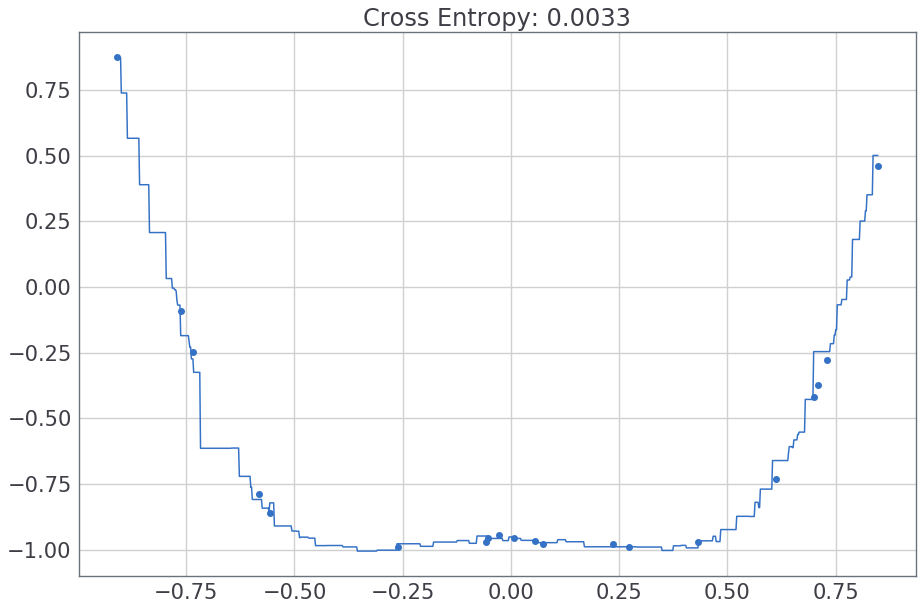

In [18]:
train_results(model)

# Random Forests

In [19]:
model = RandomForestRegressor(10, n_jobs=-1)
model.fit(np.expand_dims(x, -1), y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

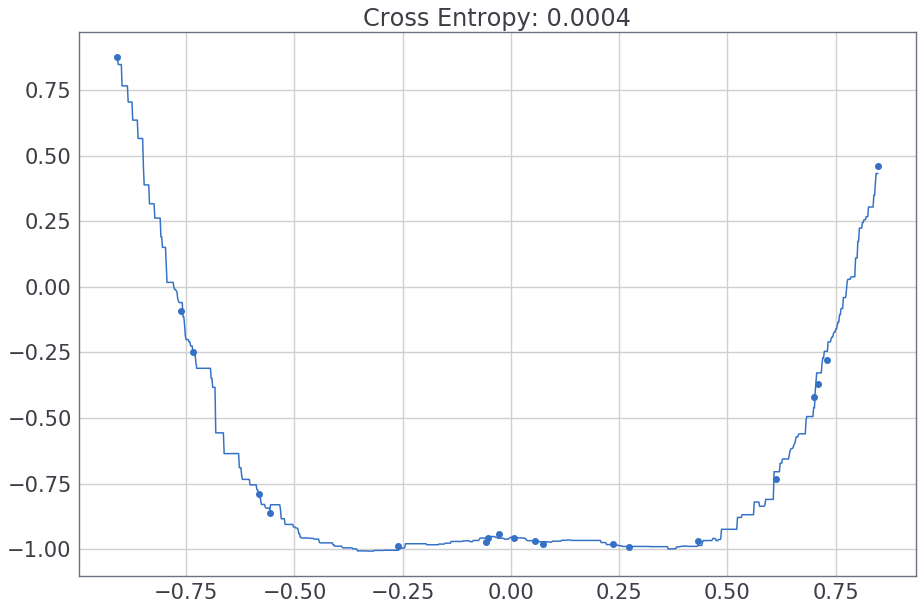

In [20]:
train_results(model)

## Smoothened

In [21]:
h = (x.max() - x.min()) / len(x)
def _predict_fn(x, n=5):
    n = int((n - 1) / 2)
    
    xs = np.expand_dims(x, -1) + np.expand_dims(np.arange(-n, n + 1) * h, 0)
    xs = np.expand_dims(xs.reshape(-1), -1)
    ys = model.predict(xs).reshape(len(x), -1)
    ys = savgol_filter(ys, ys.shape[-1], 3, axis=-1)
    return ys[:, n]

/home/vaisakh/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/vaisakh/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


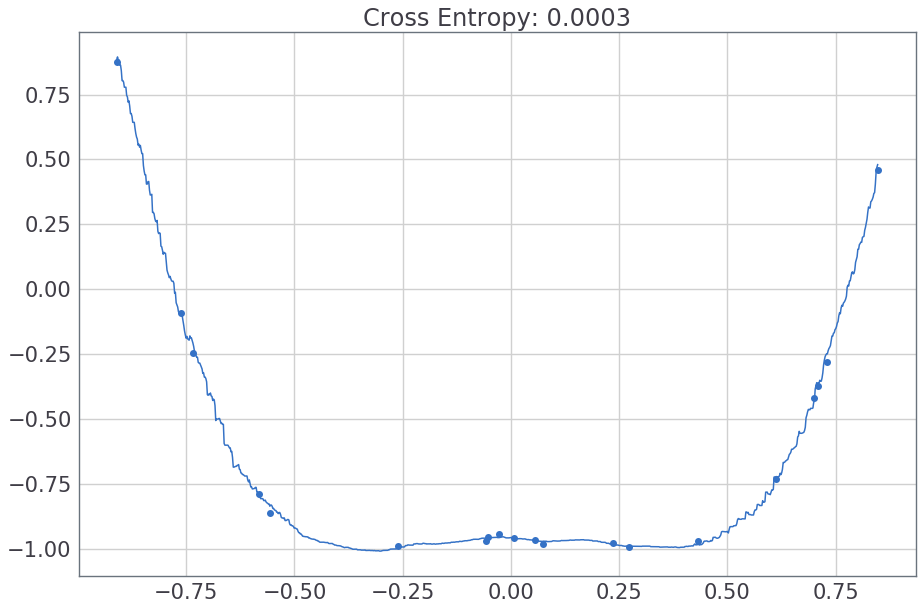

In [22]:
predict_fn = lambda x: _predict_fn(x, n=7)
train_results(model)